### Título del Proyecto  
**Clasificación de Radiografías de Tórax para la Detección de COVID-19 Utilizando Redes Neuronales Convolucionales**

---

### Descripción del Proyecto  
En este proyecto, se propone el desarrollo de un modelo de red neuronal convolucional (CNN) para la clasificación automática de radiografías de tórax en pacientes con COVID-19 y sin COVID-19. Utilizando una base de datos de imágenes médicas, el objetivo principal es construir un sistema basado en inteligencia artificial que facilite el diagnóstico clínico, mejorando la precisión y reduciendo el tiempo de detección. Este enfoque aprovecha la capacidad de las redes neuronales convolucionales para extraer características relevantes de imágenes y distinguir patrones complejos asociados con enfermedades pulmonares.  



---

### Objetivos  

#### Objetivo General  
- Desarrollar un modelo de red neuronal convolucional capaz de clasificar radiografías de tórax y detectar la presencia de COVID-19 con alta precisión.

#### Objetivos Específicos  
1. **Preprocesar la base de datos de radiografías de tórax:** Normalizar y preparar las imágenes para asegurar su calidad y compatibilidad con el modelo CNN.
2. **Diseñar y entrenar una red neuronal convolucional:** Implementar una arquitectura CNN eficiente y optimizada para la clasificación de imágenes médicas.  
3. **Validar el modelo:** Evaluar el desempeño de la CNN mediante métricas relevantes como precisión, recall, F1-Score y acurracy.  
4. Reporte el mejor resultado.

Disfruten aprendiendo. 😊

### Database

Link para descagar la base de datos [Download here](https://drive.google.com/file/d/1-RGTR_EEW1Unm2JzMCP7u0lXfenmuQaB/view?usp=sharing)


In [287]:
import torch.nn as nn
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import numpy as np
import math, os, torchvision, torch
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
import os
from shutil import copyfile
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm  # Importar tqdm para la barra de progreso

import time
from collections import Counter, defaultdict
from torchvision.models import efficientnet_b0, resnet50, vgg16_bn
from torch.nn.functional import softmax 



# Machine learning and metrics
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    auc,
    classification_report,
    confusion_matrix,
)
from sklearn.preprocessing import label_binarize

 
import platform
import psutil


In [291]:
## Adjust Here If Using Windows
## I am using a MacBook Air M2

DEVICE = torch.device("cpu" if torch.backends.mps.is_available() else "cpu") #CHANGE BY MSP IF YOU WANT
print(DEVICE)


cpu


In [289]:
# Check number of CPUs
num_cpus = psutil.cpu_count(logical=True)

# Check number of GPUs (for Macs with Apple Silicon using Metal)
def get_metal_gpus():
    try:
        import subprocess
        process = subprocess.Popen(["system_profiler", "SPDisplaysDataType"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        stdout, _ = process.communicate()
        return stdout.decode("utf-8").count("Intel")
    except Exception as e:
        return str(e)

# Get system information
system_info = platform.uname()

print(f"Operating System: {system_info.system} {system_info.release}")
print(f"Model: {system_info.machine}")
print(f"CPU Cores: {num_cpus}")
print(f"Available GPUs (using Metal): {get_metal_gpus()}")


Operating System: Darwin 24.2.0
Model: arm64
CPU Cores: 8
Available GPUs (using Metal): 0


## 1. Preprocesamiento de las imagenes

 En este paso realizamos un pre-procesamiento a las imágenes para que todas tenga el mismo tamaño, las convertimos a escala de gris, entre otras cosas.

 Esta taré ya está hecha para ustede. No debe añadir ni quitar nada.

In [10]:
PATH = '/Users/elvisrojasmonguia/Documents/Python courses/UTEC/hackaton 8 /'

In [12]:

raw_folder = PATH + '/covid_dataset/COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset'
destiny_folder = PATH + 'preprocessed/'

def process_images(category, subfolder):

    _raw_folder = os.path.join(raw_folder, category)
    _destiny_folder = os.path.join(destiny_folder, subfolder)

    # Crear la carpeta de destino si no existe
    if not os.path.exists(_destiny_folder):
        os.makedirs(_destiny_folder)

    # Obtener la lista de imágenes
    image_list = os.listdir(_raw_folder)

    # Usar tqdm para mostrar una barra de progreso
    for image in tqdm(image_list, desc=f"Procesando {category}", unit="imagen"):
        image_path = os.path.join(_raw_folder, image)
        destiny_path = os.path.join(_destiny_folder, image)

        try:
            # Copiar la imagen a la carpeta de destino
            copyfile(image_path, destiny_path)

            # Procesar la imagen
            im = Image.open(destiny_path)
            grayscale = im.convert('L')  # Convertir a escala de grises
            resized = grayscale.resize((256, 256), Image.LANCZOS)  # Redimensionar
            resized.save(destiny_path)  # Guardar la imagen procesada
        except Exception as e:
            print(f"\nError procesando {category} imagen {image}: {e}")

# Procesar las imágenes de las categorías 'Normal' y 'COVID'
process_images('Normal', 'normal')
process_images('COVID', 'covid')

Procesando COVID: 100%|█████████████████████████| 3616/3616 [00:32<00:00, 110.26imagen/s]


# 2. Creamos el DataLoader

Este código le generará el train_loader y el test_loader listo para entrenar su modelo.

Usted no debe hacer nada aquí, ya está listo para que lo use.

In [18]:

def load_images(images_path, batch_size, seed=10, data_augmentation_transform=None, include_validation=False):

    # Transformaciones básicas (siempre se aplican)
    basic_transform = transforms.Compose([
        transforms.Resize((256, 256)),  # Redimensionar a 256x256
        transforms.Grayscale(num_output_channels=1),  # Convertir a escala de grises
        transforms.ToTensor(),  # Convertir a tensor
        transforms.Normalize(mean=[0.5], std=[0.5])  # Normalizar
    ])

    # Combinar transformaciones básicas con data augmentation (si se proporciona)
    if data_augmentation_transform is not None:
        transform = transforms.Compose([
            *data_augmentation_transform.transforms,  # Transformaciones de data augmentation
            *basic_transform.transforms  # Transformaciones básicas
        ])
    else:
        transform = basic_transform

    # Cargar el dataset
    images_dataset = datasets.ImageFolder(images_path, transform=transform)

    # Contar las muestras por categoría
    class_counts = Counter(images_dataset.targets)
    class_names  = images_dataset.classes

    try:
        # Dividir el dataset en entrenamiento, validación y prueba
        if include_validation:
            train_len = int(0.6 * len(images_dataset))  # 60% para entrenamiento
            val_len = int(0.2 * len(images_dataset))    # 20% para validación
            test_len = len(images_dataset) - train_len - val_len  # 20% para prueba

            train_dataset, val_dataset, test_dataset = random_split(
                images_dataset, 
                [train_len, val_len, test_len], 
                generator=torch.Generator().manual_seed(seed)
            )
            val_loader = DataLoader(dataset=val_dataset, shuffle=False, batch_size=batch_size)
        else:
            train_len = int(0.8 * len(images_dataset))  # 80% para entrenamiento
            test_len  = len(images_dataset) - train_len  # 20% para prueba

            train_dataset, test_dataset = random_split(
                images_dataset, 
                [train_len, test_len], 
                generator=torch.Generator().manual_seed(seed)
            )
            val_loader = None

        # Crear DataLoaders
        train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=batch_size)
        test_loader = DataLoader(dataset=test_dataset, shuffle=False, batch_size=1)

        # Retornar los resultados
        if include_validation:
            return train_loader, val_loader, test_loader, class_counts, class_names
        else:
            return train_loader, test_loader, class_counts, class_names

    except ValueError as e:
        print(f"ValueError: {e}")
        return None, None, None, None, None

In [38]:
def plot_class_distribution(class_counts, class_names, title="Distribución de Clases en el Conjunto de Entrenamiento"):
    # Crear la figura y el eje
    fig, ax = plt.subplots(figsize=(12, 6))

    # Crear las barras
    bars = ax.bar(class_names, [class_counts[i] for i in range(len(class_names))], color=['skyblue', 'lightgreen', 'salmon', 'orange'])

    # Añadir valores exactos en las barras
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # Desplazamiento vertical del texto
                    textcoords="offset points",
                    ha='center', va='bottom')

    # Calcular porcentajes
    total_samples = sum(class_counts.values())
    percentages = [f'{(class_counts[i] / total_samples) * 100:.2f}%' for i in range(len(class_names))]

    # Añadir porcentajes debajo de las barras
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height / 2, percentages[i],
                ha='center', va='center', color='black', fontsize=12, fontweight='bold')

    # Personalizar el gráfico
    ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel("Clases", fontsize=14, labelpad=10)
    ax.set_ylabel("Número de Muestras", fontsize=14, labelpad=10)
    ax.tick_params(axis='x', labelsize=12, rotation=45)  # Rotar etiquetas del eje x
    ax.tick_params(axis='y', labelsize=12)

    # Añadir una cuadrícula
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Ajustar el layout para evitar cortes en las etiquetas
    plt.tight_layout()

    # Mostrar el gráfico
    plt.show()

In [30]:

# Transformaciones de data augmentation
data_augmentation_transform = transforms.Compose([
    transforms.RandomResizedCrop(256, scale=(0.8, 1.0)),  # Recorte aleatorio
    transforms.RandomHorizontalFlip(p=0.5),  # Volteo horizontal
    transforms.RandomVerticalFlip(p=0.5),  # Volteo vertical
    transforms.RandomRotation(degrees=30),  # Rotación aleatoria
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Ajuste de color
    transforms.RandomInvert(p=0.1),  # Inversión de color
    transforms.RandomAutocontrast(p=0.1),  # Autocontraste
    transforms.RandomEqualize(p=0.1),  # Igualación de histograma
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.1),  # Ajuste de nitidez
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),  # Desenfoque gaussiano
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5),  # Perspectiva aleatoria
])

SEED        = 10
BATCH_SIZE  = 16
IMAGE_PATH  = PATH + '/preprocessed'


# Cargar datos con validación
# TRAIN_LOADER, TEST_LOADER, CLASS_COUNTS, CLASS_NAMES 
TRAIN_LOADER, VAL_LOADER, TEST_LOADER, CLASS_COUNTS, CLASS_NAMES = load_images(
    images_path= IMAGE_PATH,
    batch_size=BATCH_SIZE,
    seed=SEED,
    data_augmentation_transform=None,  # Sin data augmentation
    include_validation=True  # Incluir conjunto de validación
)

print(f"Entrenamiento: {len(TRAIN_LOADER.dataset)} muestras")
print(f"Validación: {len(VAL_LOADER.dataset)} muestras")
print(f"Prueba: {len(TEST_LOADER.dataset)} muestras")



Entrenamiento: 8284 muestras
Validación: 2761 muestras
Prueba: 2763 muestras


# 3. Analisis exploratorio de datos

In [55]:
def count_classes_in_data_loader(data_loader):
    class_counts = Counter()
    for _, labels in data_loader:
        class_counts.update(labels.tolist())
    return class_counts

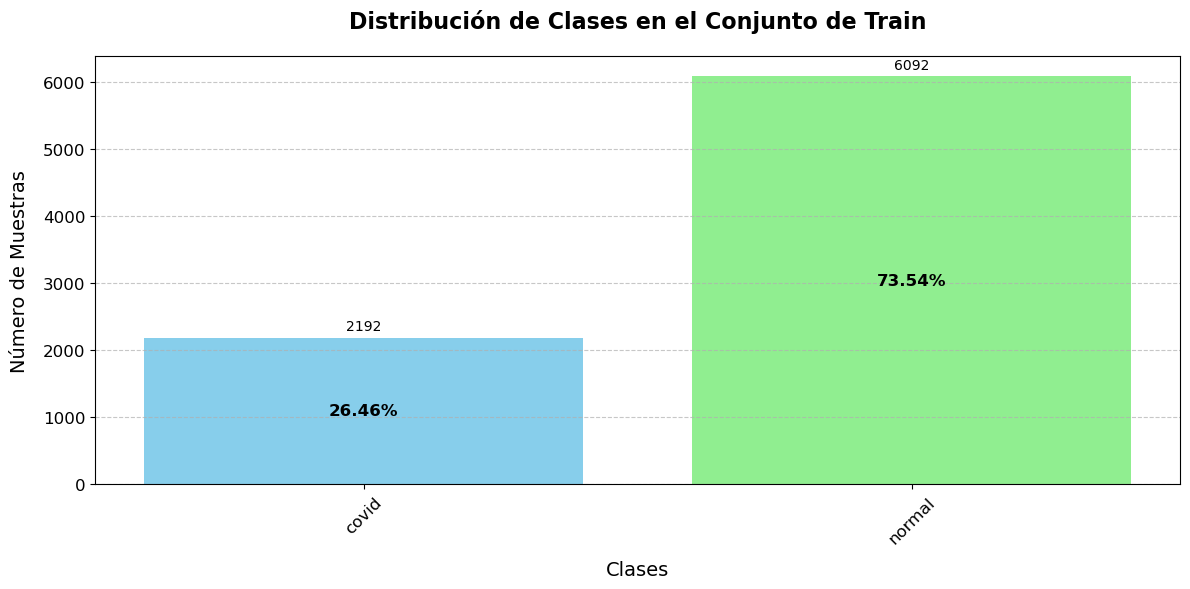

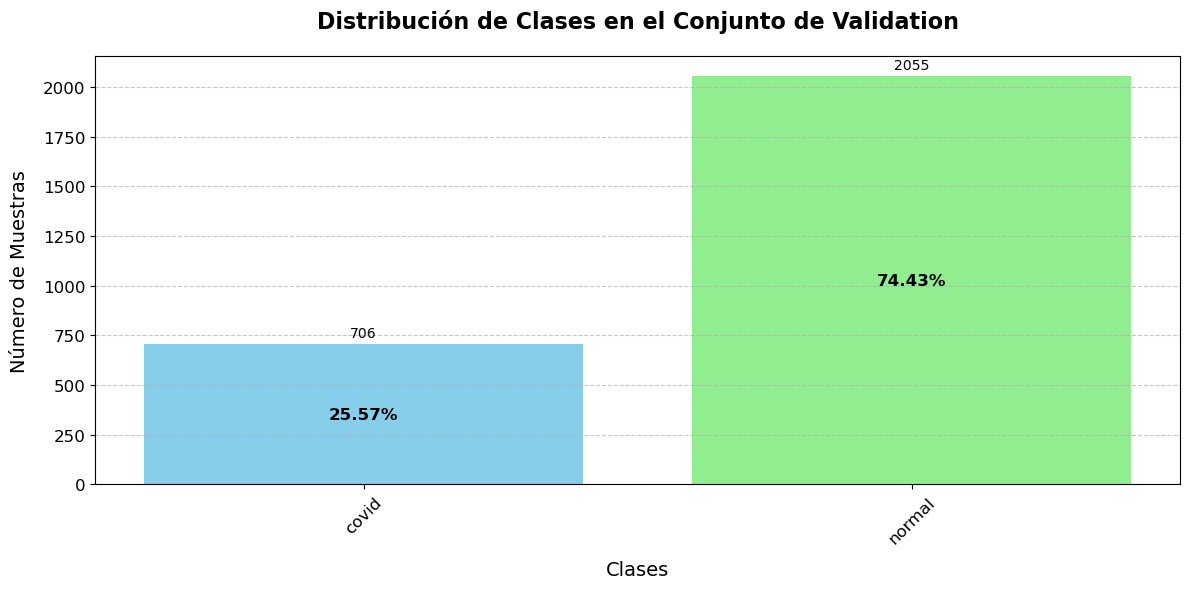

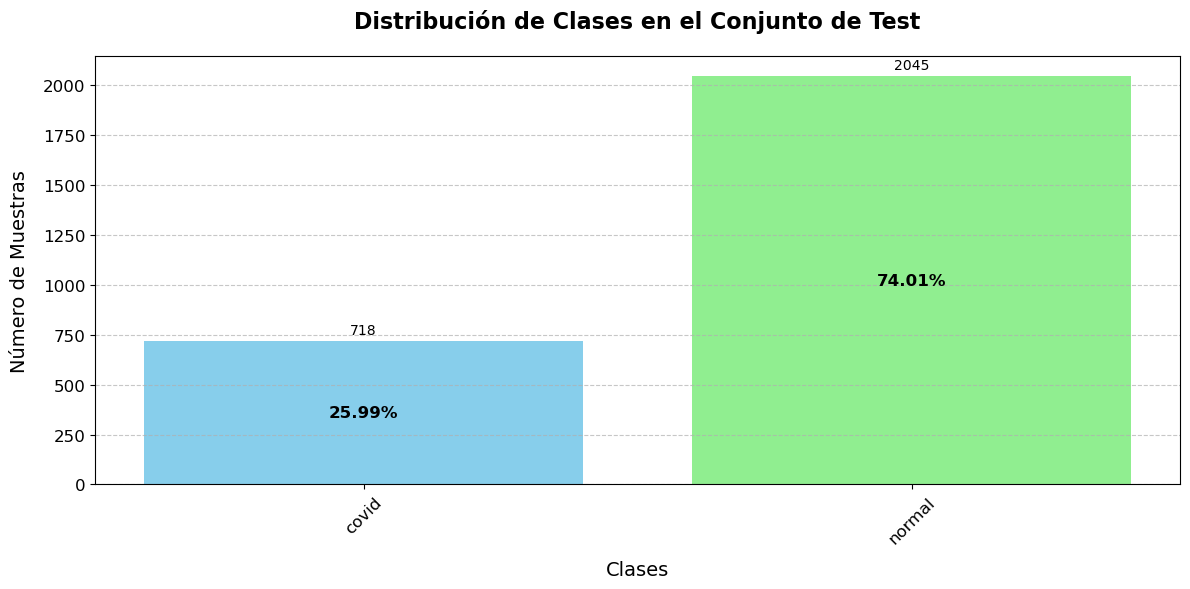

In [57]:
# Contar las clases en el conjunto de entrenamiento
train_class_counts = count_classes_in_data_loader(TRAIN_LOADER)
val_class_counts = count_classes_in_data_loader(VAL_LOADER)
test_class_counts = count_classes_in_data_loader(TEST_LOADER)


# Graficar la distribución de clases del conjunto de entrenamiento
plot_class_distribution(train_class_counts, CLASS_NAMES, title="Distribución de Clases en el Conjunto de Train")
plot_class_distribution(val_class_counts, CLASS_NAMES, title="Distribución de Clases en el Conjunto de Validation")
plot_class_distribution(test_class_counts, CLASS_NAMES, title="Distribución de Clases en el Conjunto de Test")


In [ ]:
def calculate_class_weights(class_counts):
    total_samples = sum(class_counts.values())
    num_classes = len(class_counts)
    class_weights = {class_id: total_samples / (num_classes * count) for class_id, count in class_counts.items()}
    return class_weights

In [59]:
# Calcular los pesos de las clases basados en el conjunto de entrenamiento
class_weights_dict = calculate_class_weights(train_class_counts)
print("Pesos de las clases (entrenamiento):", class_weights_dict)

# Convertir los pesos a un tensor
WEIGHTS_TENSOR = torch.tensor(list(class_weights_dict.values()), dtype=torch.float32).to(DEVICE)
print("Pesos de las clases (tensor):", WEIGHTS_TENSOR)

Pesos de las clases (entrenamiento): {1: 0.6799080761654629, 0: 1.8895985401459854}
Pesos de las clases (tensor): tensor([0.6799, 1.8896])


In [62]:
# Obtener un lote de datos del train_loader
train_images, train_labels = next(iter(TRAIN_LOADER))

# Obtener un lote de datos del test_loader
test_images, test_labels = next(iter(TEST_LOADER))

# Imprimir las dimensiones
print("Dimensiones de train_loader:")
print(f"Imágenes: {train_images.shape}")  # Debería ser (batch_size, 1, 256, 256)
print(f"Etiquetas: {train_labels.shape}")  # Debería ser (batch_size,)

print("\nDimensiones de test_loader:")
print(f"Imágenes: {test_images.shape}")  # Debería ser (1, 1, 256, 256)
print(f"Etiquetas: {test_labels.shape}")  # Debería ser (1,)

Dimensiones de train_loader:
Imágenes: torch.Size([16, 1, 256, 256])
Etiquetas: torch.Size([16])

Dimensiones de test_loader:
Imágenes: torch.Size([1, 1, 256, 256])
Etiquetas: torch.Size([1])


In [64]:

def Show_img(images, names, size=5, color=True):

    color_m = 'jet' if color else 'gray'

    # Crear una figura con subplots de 1 fila y 2 columnas
    fig, axes = plt.subplots(1, 2, figsize=(size * 2, size))

    # Asegurarse de que axes sea una lista (en caso de solo una imagen)
    if not isinstance(axes, (list, np.ndarray)):
        axes = [axes]

    # Mostrar cada imagen en su respectivo subplot
    for i, (img, name) in enumerate(zip(images, names)):
        ax = axes[i]

        # Asegurarse de que la imagen tenga la forma correcta (H, W)
        if img.dim() == 3:  # Si la imagen tiene forma (1, H, W)
            img = img.squeeze(0)  # Eliminar la dimensión del canal

        # Desnormalizar la imagen
        img = img.detach().numpy()  # Convertir a NumPy
        img = img * 0.5 + 0.5  # Desnormalizar (si estaba normalizada con mean=0.5, std=0.5)

        # Mostrar la imagen en el subplot
        ax.imshow(img, cmap=color_m)
        ax.axis('off')  # Ocultar ejes
        ax.set_title(name, fontsize=12, fontweight='bold')

    # Ajustar el layout para evitar superposiciones
    plt.tight_layout()

    # Mostrar el gráfico
    plt.show()


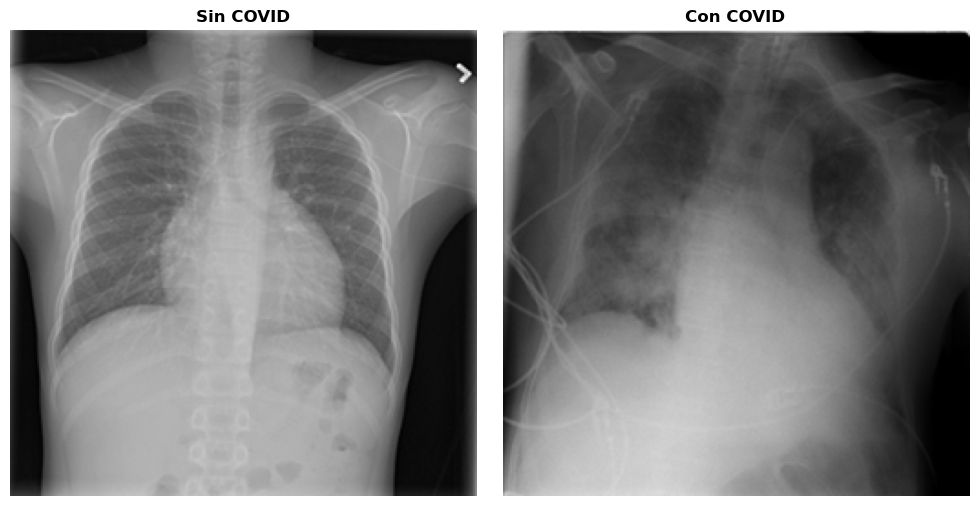

In [317]:
# Obtener un lote de datos del train_loader
train_images, train_labels = next(iter(TRAIN_LOADER))

# Seleccionar un ejemplo de cada categoría
covid_image = None ; normal_image = None

for img, label in zip(train_images, train_labels):
    if label == 1 and normal_image is None:  # COVID
        normal_image = img
    elif label == 0 and covid_image is None:  # Normal
        covid_image = img
    if covid_image is not None and normal_image is not None:
        break

# Mostrar las imágenes en un subplot de 1x2
Show_img(images=[normal_image, covid_image],
         names=["Sin COVID", "Con COVID"],
         size=5,
         color=False)

- Creando códigos de CNN  
Aquí, tu equipo implementará su red neuronal convolucional (CNN).

- Utiliza capas de convolución (convolución, ReLU, MaxPooling).  
- Utiliza al menos 2 capas ocultas al final de tu red. Ten en cuenta que el número de neuronas finales depende del número de clases que estás clasificando.  
- Analiza para qué se utiliza la normalización por lotes (Batch Normalization) y aplícala en tu red.  
  [enlace](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html)  
- Analiza para qué se utiliza Dropout y aplícalo en algunas de tus capas.  
  [enlace](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html)  
- Compara los resultados con aquellos obtenidos sin utilizar Batch Normalization y Dropout.  


# 4. Training all models
This function is responsible for performing the training.

In [121]:
class Callback:
    """Base callback class defining the interface for all callbacks"""
    def __init__(self):
        self.model_name = None
        
    def on_train_begin(self, logs=None):
        """Called at the beginning of training"""
        self.model_name = logs.get('model_name', 'model')

    def on_train_end(self, logs=None):
        """Called at the end of training"""
        pass

    def on_epoch_begin(self, epoch, logs=None):
        """Called at the beginning of each epoch"""
        pass

    def on_epoch_end(self, epoch, logs=None):
        """Called at the end of each epoch"""
        pass

    def on_batch_begin(self, batch, logs=None):
        """Called at the beginning of each batch"""
        pass

    def on_batch_end(self, batch, logs=None):
        """Called at the end of each batch"""
        pass

class EarlyStoppingCallback(Callback):
    """Stop training when validation loss stops improving"""
    def __init__(self, patience=5):
        super().__init__()
        self.patience = patience
        self.reset_state()
        
    def reset_state(self):
        self.best_val_loss = float('inf')
        self.wait = 0
        self.stopped_epoch = 0
        self.stop_training = False

    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs.get('val_loss', float('inf'))
        print(f"[{self.model_name}] Epoch {epoch+1} - Val Loss: {val_loss:.4f} | Best: {self.best_val_loss:.4f} | Wait: {self.wait}/{self.patience}")  # Debug
        
        if val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.stop_training = True
                print(f"\n[{self.model_name}] Early stopping triggered at epoch {epoch + 1}")

class SaveBestModelCallback(Callback):
    """Save the best model based on validation loss"""
    def __init__(self, base_save_path):
        super().__init__()
        self.base_save_path = base_save_path
        self.best_val_loss = float('inf')
        os.makedirs(os.path.dirname(base_save_path), exist_ok=True)

    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs.get('val_loss')
        model = logs.get('model')
        
        if val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            save_path = f"{self.base_save_path}_{self.model_name}.pth"
            torch.save(model.state_dict(), save_path)
            print(f"\n[{self.model_name}] Best model saved at {save_path} (val_loss: {val_loss:.4f})")

def get_callbacks():
    """Factory function to create new callback instances"""
    return [
        SaveBestModelCallback("models/best_model"),
        EarlyStoppingCallback(patience=5)
    ]

def train_and_evaluate_all_models(models, train_loader, val_loader,
                                 loss_fn, optimizer_fn, num_epochs, device, callbacks_factory):
    """
    Modified function with critical fixes:
    1. Separate callbacks per model
    2. Proper state reset
    3. Improved error handling
    """
    results = defaultdict(dict)
    histories = defaultdict(dict)
    execution_times = {}

    for model_name, model_builder in models.items():
        start_time = time.time()
        print(f"\n{'='*40}\nTraining {model_name}\n{'='*40}")
        
        # Create fresh callbacks for each model
        callbacks = callbacks_factory()
        
        # Model initialization
        try:
            model = model_builder().to(device)
            optimizer = optimizer_fn(model.parameters())
        except Exception as e:
            print(f"Error initializing {model_name}: {str(e)}")
            continue

        # Initialize metrics storage
        history = defaultdict(lambda: defaultdict(list))

        # Initialize callbacks
        for callback in callbacks:
            callback.on_train_begin(logs={'model': model, 'model_name': model_name})

        # Training loop
        try:
            for epoch in range(num_epochs):
                epoch_start_time = time.time()  # Start time for the epoch
                
                if any(getattr(cb, 'stop_training', False) for cb in callbacks):
                    print(f"Early stopping triggered for {model_name}")
                    break

                # Training phase
                model.train()
                train_metrics = _run_epoch(model, train_loader, loss_fn, optimizer, device, is_training=True)
                
                # Validation phase
                model.eval()
                with torch.no_grad():
                    val_metrics = _run_epoch(model, val_loader, loss_fn, None, device, is_training=False)

                # Update history
                for metric in ['loss', 'accuracy', 'f1']:
                    history['train'][metric].append(train_metrics[metric])
                    history['val'][metric].append(val_metrics[metric])

                # Callback handling
                logs = {
                    'epoch': epoch,
                    'model': model,
                    'model_name': model_name,
                    'val_loss': val_metrics['loss'],
                    **{f'train_{k}': v for k, v in train_metrics.items()},
                    **{f'val_{k}': v for k, v in val_metrics.items()}
                }
                
                for callback in callbacks:
                    callback.on_epoch_end(epoch, logs=logs)
 
                # Calculate epoch time
                epoch_time = time.time() - epoch_start_time

                # Print epoch summary with epoch time
                _print_epoch_summary(epoch, num_epochs, train_metrics, val_metrics, epoch_time)

        
        except Exception as e:
            print(f"Error training {model_name}: {str(e)}")
            continue

        # Final callback handling
        for callback in callbacks:
            callback.on_train_end(logs={'model': model})

        # Store results
        results[model_name] = {
            "train_accuracy": history["train"]["accuracy"][-1],
            "val_accuracy": history["val"]["accuracy"][-1],
            "train_loss": history["train"]["loss"][-1],
            "val_loss": history["val"]["loss"][-1],
            "train_F1": history["train"]["f1"][-1],
            "val_F1": history["val"]["f1"][-1],              
        }
        histories[model_name] = history
        execution_times[model_name] = time.time() - start_time

    return dict(results), dict(histories), execution_times

 
def _run_epoch(model, data_loader, loss_fn, optimizer, device, is_training=True):
    """Helper function to run a single epoch"""
    metrics = defaultdict(float)
    all_targets = []
    all_outputs = []

    progress_bar = tqdm(data_loader, desc='Training' if is_training else 'Validation')
    for batch_idx, (images, labels) in enumerate(progress_bar):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        # Backward pass and optimization
        if is_training and optimizer is not None:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Store metrics
        metrics['loss'] += loss.item() * images.size(0)
        all_targets.extend(labels.cpu().numpy())
        all_outputs.extend(softmax(outputs, dim=1).detach().cpu().numpy())

        # Update progress bar
        if batch_idx % 10 == 0:
            progress_bar.set_postfix(loss=loss.item())

    # Calculate final metrics
    metrics['loss'] /= len(data_loader.dataset)
    predictions = np.argmax(all_outputs, axis=1)
    
    metrics['accuracy'] = accuracy_score(all_targets, predictions)
    metrics['f1'] = f1_score(all_targets, predictions, average='weighted')

    return metrics

def _print_epoch_summary(epoch, total_epochs, train_metrics, val_metrics, epoch_time):
    """Print formatted epoch summary"""
    print(f"\nEpoch {epoch+1}/{total_epochs}: took {epoch_time / 60:.2f} minutes")
    print(f"Train Loss: {train_metrics['loss']:.4f} | "
          f"Accuracy: {train_metrics['accuracy']:.4f} | "
          f"F1: {train_metrics['f1']:.4f}")
    print(f"Val Loss:   {val_metrics['loss']:.4f} | "
          f"Accuracy: {val_metrics['accuracy']:.4f} | "
          f"F1: {val_metrics['f1']:.4f}")

In [123]:
## coleccion de modelo CNN con arquitecturas personalizadas

## Modelo con 2 convoluciones, sin capas BatchNorm ni  Dropout. una sola capa oculta.

class CNN_Model1(nn.Module):
    def __init__(self, num_classes=2):
        super(CNN_Model1, self).__init__()
        # Capa 1: Convolución + ReLU + MaxPooling
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Capa 2: Convolución + ReLU + MaxPooling
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Capa fully connected
        self.fc = nn.Linear(32*64*64, num_classes)  #  32*64*64

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)  # Aplanar la salida
        out = self.fc(out)
        return out

## Modelo con 2 convoluciones, con capas BatchNorm y  Dropout en la convolucion y oculta, respectivamente

class CNN_Model2(nn.Module):
    def __init__(self, num_classes=2):
        super(CNN_Model2, self).__init__()
        # Capa 1: Convolución + BatchNorm + ReLU + MaxPooling
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Capa 2: Convolución + BatchNorm + ReLU + MaxPooling
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Capa fully connected con Dropout
        self.fc = nn.Sequential(
            nn.Linear(32*64*64, 128),  #  32*64*64
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)  # Aplanar la salida
        out = self.fc(out)
        return out


## Modelo con mayor profundidad, 3 convoluciones con BatchNorm y dropout en la capas ocultas
class CNN_Model3(nn.Module):
    def __init__(self, num_classes=2):
        super(CNN_Model3, self).__init__()
        # Capa 1: Convolución + BatchNorm + ReLU + MaxPooling
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Capa 2: Convolución + BatchNorm + ReLU + MaxPooling
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Capa 3: Convolución + BatchNorm + ReLU + MaxPooling
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=7, stride=1, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Capas fully connected con Dropout
        self.fc = nn.Sequential(
            nn.Linear(32*32*64, 256),  # Primera capa oculta
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout para regularización, aqui podemos cambiar el valor del dropout
            nn.Linear(256, 128),  # Segunda capa oculta
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout para regularización,  aqui podemos cambiar el valor del dropout
            nn.Linear(128, num_classes)  # Capa de salida
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)  # Aplanar la salida
        out = self.fc(out)
        return out

## Ejecucion de modelos CNN - personalizados

In [141]:
NUM_CLASSES   = 2
LEARNING_RATE = 0.001
NUM_EPOCHS    = 3


def cnn_builder_1(num_classes=NUM_CLASSES):
    return CNN_Model1(num_classes=num_classes)

def cnn_builder_2(num_classes=NUM_CLASSES):
    return CNN_Model2(num_classes=num_classes)


def cnn_builder_3(num_classes=NUM_CLASSES):
    return CNN_Model3(num_classes=num_classes)

 
# Model configuration
MODELS_NO_PRETRAINED = {
    "CNN_Model1": cnn_builder_1,
    "CNN_Model2": cnn_builder_2,
    "CNN_Model3": cnn_builder_3,
}


# Training execution
if __name__ == "__main__":
    print(f"Using device: {DEVICE}")

    def optimizer_fn(params):
        return optim.Adam(
            filter(lambda p: p.requires_grad, params),
            lr=LEARNING_RATE
        )

    # Execute training with callback factory
    results, histories, execution_times = train_and_evaluate_all_models(
        models=MODELS_NO_PRETRAINED,
        train_loader= TRAIN_LOADER,
        val_loader= VAL_LOADER,
        loss_fn=nn.CrossEntropyLoss(weight=WEIGHTS_TENSOR),
        optimizer_fn=optimizer_fn,
        num_epochs=NUM_EPOCHS,
        device=DEVICE,
        callbacks_factory=get_callbacks  # Usamos la fábrica de callbacks
    )


Using device: cpu

Training CNN_Model1


Validation: 100%|██████████████████████████| 173/173 [00:18<00:00,  9.34it/s, loss=0.121]



[CNN_Model1] Best model saved at models/best_model_CNN_Model1.pth (val_loss: 0.1711)
[CNN_Model1] Epoch 1 - Val Loss: 0.1711 | Best: inf | Wait: 0/5

Epoch 1/3: took 2.37 minutes
Train Loss: 0.2419 | Accuracy: 0.8199 | F1: 0.7905
Val Loss:   0.1711 | Accuracy: 0.8964 | F1: 0.8905


Validation: 100%|██████████████████████████| 173/173 [00:22<00:00,  7.79it/s, loss=0.188]



[CNN_Model1] Best model saved at models/best_model_CNN_Model1.pth (val_loss: 0.1381)
[CNN_Model1] Epoch 2 - Val Loss: 0.1381 | Best: 0.1711 | Wait: 0/5

Epoch 2/3: took 2.99 minutes
Train Loss: 0.1301 | Accuracy: 0.9159 | F1: 0.9121
Val Loss:   0.1381 | Accuracy: 0.9308 | F1: 0.9296


Validation: 100%|██████████████████████████| 173/173 [00:22<00:00,  7.77it/s, loss=0.147]



[CNN_Model1] Best model saved at models/best_model_CNN_Model1.pth (val_loss: 0.1336)
[CNN_Model1] Epoch 3 - Val Loss: 0.1336 | Best: 0.1381 | Wait: 0/5

Epoch 3/3: took 3.19 minutes
Train Loss: 0.0836 | Accuracy: 0.9491 | F1: 0.9478
Val Loss:   0.1336 | Accuracy: 0.9279 | F1: 0.9265

Training CNN_Model2


Validation: 100%|██████████████████████████| 173/173 [00:32<00:00,  5.30it/s, loss=0.125]



[CNN_Model2] Best model saved at models/best_model_CNN_Model2.pth (val_loss: 0.1940)
[CNN_Model2] Epoch 1 - Val Loss: 0.1940 | Best: inf | Wait: 0/5

Epoch 1/3: took 5.99 minutes
Train Loss: 0.6901 | Accuracy: 0.7749 | F1: 0.7230
Val Loss:   0.1940 | Accuracy: 0.8645 | F1: 0.8509


Validation: 100%|██████████████████████████| 173/173 [00:24<00:00,  7.18it/s, loss=0.115]



[CNN_Model2] Best model saved at models/best_model_CNN_Model2.pth (val_loss: 0.1713)
[CNN_Model2] Epoch 2 - Val Loss: 0.1713 | Best: 0.1940 | Wait: 0/5

Epoch 2/3: took 4.49 minutes
Train Loss: 0.2246 | Accuracy: 0.7953 | F1: 0.7488
Val Loss:   0.1713 | Accuracy: 0.8790 | F1: 0.8682


Validation: 100%|██████████████████████████| 173/173 [00:25<00:00,  6.78it/s, loss=0.103]



[CNN_Model2] Best model saved at models/best_model_CNN_Model2.pth (val_loss: 0.1635)
[CNN_Model2] Epoch 3 - Val Loss: 0.1635 | Best: 0.1713 | Wait: 0/5

Epoch 3/3: took 3.73 minutes
Train Loss: 0.1962 | Accuracy: 0.8193 | F1: 0.7872
Val Loss:   0.1635 | Accuracy: 0.9066 | F1: 0.9008

Training CNN_Model3


Validation: 100%|██████████████████████████| 173/173 [00:35<00:00,  4.81it/s, loss=0.174]



[CNN_Model3] Best model saved at models/best_model_CNN_Model3.pth (val_loss: 0.2471)
[CNN_Model3] Epoch 1 - Val Loss: 0.2471 | Best: inf | Wait: 0/5

Epoch 1/3: took 10.84 minutes
Train Loss: 0.5640 | Accuracy: 0.7269 | F1: 0.6463
Val Loss:   0.2471 | Accuracy: 0.7443 | F1: 0.6352


Validation: 100%|██████████████████████████| 173/173 [00:35<00:00,  4.84it/s, loss=0.108]



[CNN_Model3] Best model saved at models/best_model_CNN_Model3.pth (val_loss: 0.2083)
[CNN_Model3] Epoch 2 - Val Loss: 0.2083 | Best: 0.2471 | Wait: 0/5

Epoch 2/3: took 9.80 minutes
Train Loss: 0.2544 | Accuracy: 0.7388 | F1: 0.6327
Val Loss:   0.2083 | Accuracy: 0.7443 | F1: 0.6352


Validation: 100%|█████████████████████████| 173/173 [00:51<00:00,  3.34it/s, loss=0.0998]



[CNN_Model3] Best model saved at models/best_model_CNN_Model3.pth (val_loss: 0.1720)
[CNN_Model3] Epoch 3 - Val Loss: 0.1720 | Best: 0.2083 | Wait: 0/5

Epoch 3/3: took 9.80 minutes
Train Loss: 0.2128 | Accuracy: 0.7997 | F1: 0.7652
Val Loss:   0.1720 | Accuracy: 0.8787 | F1: 0.8665


##  Ejecucion de modelos pre-trained 

In [145]:
# Model builder functions with num_classes parameter
def efficientnet_builder(num_classes=NUM_CLASSES):
    model = efficientnet_b0(weights="DEFAULT")  # 
    # Modificar la primera capa convolucional para aceptar 1 canal (images en blanco y negro como fue procesado en la seccion 1)
    model.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False) # de acuerdo a la entrada del modelo EfficientNet
    # Congelar todos los parámetros excepto los de la última capa
    for param in model.parameters():
        param.requires_grad = False
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    for param in model.features[-1].parameters():
        param.requires_grad = True
    return model

def resnet_builder(num_classes=NUM_CLASSES):
    model = resnet50(weights="DEFAULT")   
    # Modificar la primera capa convolucional para aceptar 1 canal (images en blanco y negro como fue procesado en la seccion 1)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  # de acuerdo a la entrada del modelo Resnet
    # Congelar todos los parámetros excepto los de la última capa
    for param in model.parameters():
        param.requires_grad = False
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    for param in model.layer4.parameters():
        param.requires_grad = True
    return model
    
def vgg_builder(num_classes=NUM_CLASSES):
    model = vgg16_bn(weights="DEFAULT")   
    # Modificar la primera capa convolucional para aceptar 1 canal (images en blanco y negro como fue procesado en la seccion 1)
    model.features[0] = nn.Conv2d(1, 64, kernel_size=3, padding=1)  # de acuerdo a la entrada del modelo VGG
    # Congelar todos los parámetros excepto los de la última capa
    for param in model.features.parameters():
        param.requires_grad = False
    model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    for param in model.features[-4:].parameters():
        param.requires_grad = True
    return model

# Model configuration
MODELS_PRETRAINED = {
    "EfficientNet": efficientnet_builder,
    "ResNet": resnet_builder,
    "VGG": vgg_builder,
}


# Training execution
if __name__ == "__main__":
    print(f"Using device: {DEVICE}")

    def optimizer_fn(params):
        return optim.Adam(
            filter(lambda p: p.requires_grad, params),
            lr=LEARNING_RATE
        )

    # Execute training with callback factory
    results_pretrained, histories_pretrained, execution_times_pretrained = train_and_evaluate_all_models(
        models=MODELS_PRETRAINED,
        train_loader= TRAIN_LOADER,
        val_loader= VAL_LOADER,
        loss_fn=nn.CrossEntropyLoss(weight=WEIGHTS_TENSOR),
        optimizer_fn=optimizer_fn,
        num_epochs=NUM_EPOCHS,
        device=DEVICE,
        callbacks_factory=get_callbacks  # Usamos la fábrica de callbacks
    )

Using device: cpu

Training EfficientNet


Validation: 100%|████████████████████████| 173/173 [05:11<00:00,  1.80s/it, loss=0.00215]



[EfficientNet] Best model saved at models/best_model_EfficientNet.pth (val_loss: 0.0760)
[EfficientNet] Epoch 1 - Val Loss: 0.0760 | Best: inf | Wait: 0/5

Epoch 1/3: took 23.60 minutes
Train Loss: 0.1579 | Accuracy: 0.8898 | F1: 0.8829
Val Loss:   0.0760 | Accuracy: 0.9446 | F1: 0.9426


Validation: 100%|████████████████████████| 173/173 [05:02<00:00,  1.75s/it, loss=0.00536]



[EfficientNet] Best model saved at models/best_model_EfficientNet.pth (val_loss: 0.0651)
[EfficientNet] Epoch 2 - Val Loss: 0.0651 | Best: 0.0760 | Wait: 0/5

Epoch 2/3: took 21.80 minutes
Train Loss: 0.0952 | Accuracy: 0.9406 | F1: 0.9391
Val Loss:   0.0651 | Accuracy: 0.9605 | F1: 0.9597


Validation: 100%|████████████████████████| 173/173 [04:48<00:00,  1.67s/it, loss=0.00181]



[EfficientNet] Best model saved at models/best_model_EfficientNet.pth (val_loss: 0.0586)
[EfficientNet] Epoch 3 - Val Loss: 0.0586 | Best: 0.0651 | Wait: 0/5

Epoch 3/3: took 19.78 minutes
Train Loss: 0.0713 | Accuracy: 0.9555 | F1: 0.9546
Val Loss:   0.0586 | Accuracy: 0.9598 | F1: 0.9587

Training ResNet


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /Users/elvisrojasmonguia/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|███████████████████████████████████████████████| 97.8M/97.8M [01:35<00:00, 1.07MB/s]
Validation: 100%|█████████████████████████| 173/173 [08:42<00:00,  3.02s/it, loss=0.0529]



[ResNet] Best model saved at models/best_model_ResNet.pth (val_loss: 0.0646)
[ResNet] Epoch 1 - Val Loss: 0.0646 | Best: inf | Wait: 0/5

Epoch 1/3: took 39.51 minutes
Train Loss: 0.1186 | Accuracy: 0.9219 | F1: 0.9184
Val Loss:   0.0646 | Accuracy: 0.9670 | F1: 0.9665


Validation: 100%|██████████████████████████| 173/173 [08:27<00:00,  2.93s/it, loss=0.122]



[ResNet] Best model saved at models/best_model_ResNet.pth (val_loss: 0.0521)
[ResNet] Epoch 2 - Val Loss: 0.0521 | Best: 0.0646 | Wait: 0/5

Epoch 2/3: took 37.22 minutes
Train Loss: 0.0497 | Accuracy: 0.9714 | F1: 0.9711
Val Loss:   0.0521 | Accuracy: 0.9790 | F1: 0.9788


Validation: 100%|█████████████████████████| 173/173 [08:24<00:00,  2.92s/it, loss=0.0182]


[ResNet] Epoch 3 - Val Loss: 0.0573 | Best: 0.0521 | Wait: 0/5

Epoch 3/3: took 36.55 minutes
Train Loss: 0.0232 | Accuracy: 0.9872 | F1: 0.9872
Val Loss:   0.0573 | Accuracy: 0.9746 | F1: 0.9745

Training VGG


Validation: 100%|█████████████████████████| 173/173 [08:29<00:00,  2.95s/it, loss=0.0787]



[VGG] Best model saved at models/best_model_VGG.pth (val_loss: 0.0766)
[VGG] Epoch 1 - Val Loss: 0.0766 | Best: inf | Wait: 0/5

Epoch 1/3: took 41.10 minutes
Train Loss: 0.2133 | Accuracy: 0.9128 | F1: 0.9101
Val Loss:   0.0766 | Accuracy: 0.9696 | F1: 0.9690


Validation: 100%|█████████████████████████| 173/173 [08:28<00:00,  2.94s/it, loss=0.0414]



[VGG] Best model saved at models/best_model_VGG.pth (val_loss: 0.0592)
[VGG] Epoch 2 - Val Loss: 0.0592 | Best: 0.0766 | Wait: 0/5

Epoch 2/3: took 41.24 minutes
Train Loss: 0.0771 | Accuracy: 0.9619 | F1: 0.9613
Val Loss:   0.0592 | Accuracy: 0.9728 | F1: 0.9725


Validation: 100%|██████████████████████████| 173/173 [08:25<00:00,  2.92s/it, loss=0.048]

[VGG] Epoch 3 - Val Loss: 0.0633 | Best: 0.0592 | Wait: 0/5

Epoch 3/3: took 41.79 minutes
Train Loss: 0.0546 | Accuracy: 0.9731 | F1: 0.9728
Val Loss:   0.0633 | Accuracy: 0.9707 | F1: 0.9701


# Comparacion de modelos

In [189]:
def _evaluate_model(model, test_loader, weights_tensor, device):
    loss_fn = nn.CrossEntropyLoss(weight=weights_tensor).to(DEVICE)
    model.eval()
    correct = 0
    total = 0
    total_loss = 0.0
    
    # Usar tqdm para mostrar el progreso
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating", unit="batch"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = correct / total
    avg_loss = total_loss / len(test_loader)
    return accuracy, avg_loss
    
def evaluate_on_test_set(models, test_loader, weights_tensor, device, path):
    test_results = {}
    
    for model_name, model_fn in models.items():
        print(f"Evaluating {model_name}...")
        
        # Load the model
        model = model_fn().to(device)
        model_path = f"{path}best_model_{model_name}.pth"
        
        # Load model weights with weights_only=True for security
        model.load_state_dict(torch.load(model_path, weights_only=True))
        model.eval()
        
        # Evaluate on the test set
        test_accuracy, test_loss = _evaluate_model(model, test_loader, weights_tensor, device)
        
        # Store results
        test_results[model_name] = {
            "test_accuracy": test_accuracy,
            "test_loss": test_loss
        }
        print(f"{model_name} - Test Accuracy: {test_accuracy*100:.2f}%, Test Loss: {test_loss:.4f}")
    
    return test_results

In [193]:
# Unir los resultados de los modelos no preentrenados y preentrenados
all_results = {**results, **results_pretrained}
all_histories = {**histories, **histories_pretrained}
all_execution_times = {**execution_times, **execution_times_pretrained}
all_models = {**MODELS_NO_PRETRAINED, **MODELS_PRETRAINED}

In [196]:
# Execute evaluation on the test set
## calculamos las metricas de desempeno en TEST de  todos los modelos para compararlos

MODELS_SAVED_PATH = PATH + "models/"
test_results = evaluate_on_test_set(all_models, TEST_LOADER, WEIGHTS_TENSOR, DEVICE, MODELS_SAVED_PATH)

Evaluating CNN_Model1...


Evaluating: 100%|████████████████████████████████| 2763/2763 [00:14<00:00, 191.20batch/s]


CNN_Model1 - Test Accuracy: 93.88%, Test Loss: 0.1994
Evaluating CNN_Model2...


Evaluating: 100%|████████████████████████████████| 2763/2763 [00:25<00:00, 109.98batch/s]


CNN_Model2 - Test Accuracy: 90.63%, Test Loss: 0.3215
Evaluating CNN_Model3...


Evaluating: 100%|█████████████████████████████████| 2763/2763 [00:43<00:00, 63.85batch/s]


CNN_Model3 - Test Accuracy: 86.64%, Test Loss: 0.3129
Evaluating EfficientNet...


Evaluating: 100%|█████████████████████████████████| 2763/2763 [01:56<00:00, 23.68batch/s]


EfficientNet - Test Accuracy: 96.16%, Test Loss: 0.1141
Evaluating ResNet...


Evaluating: 100%|█████████████████████████████████| 2763/2763 [01:57<00:00, 23.49batch/s]


ResNet - Test Accuracy: 97.54%, Test Loss: 0.0872
Evaluating VGG...


Evaluating: 100%|█████████████████████████████████| 2763/2763 [07:31<00:00,  6.12batch/s]

VGG - Test Accuracy: 97.14%, Test Loss: 0.1104


In [214]:
## calculamos las metricas de desempeno en TEST de  todos los modelos para compararlos
model_names = list(all_results.keys())
accuracies = {'Train': [], 'Validation': [], 'Test': []}

# Populate accuracies from results and test_results
for model in model_names:
    accuracies['Train'].append(all_results[model]['train_accuracy'] * 100)
    accuracies['Validation'].append(all_results[model]['val_accuracy'] * 100)
    accuracies['Test'].append(test_results[model]['test_accuracy'] * 100)


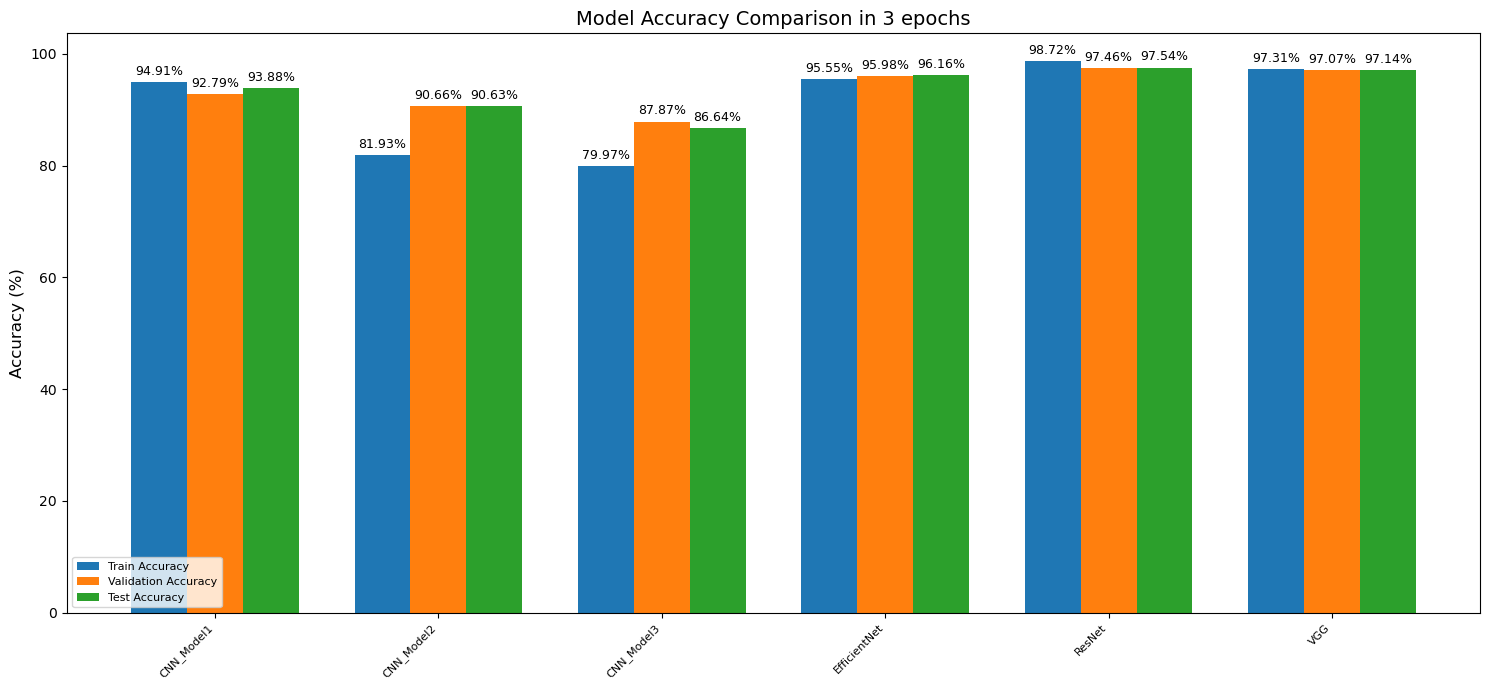

In [234]:
# =============================================
# FIRST PLOT: Model Performance Comparison (Accuracy)
# =============================================

x = np.arange(len(model_names))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(15, 7))
# Create the bars for train, validation, and test accuracies
rects = {key: ax.bar(x + (i - 1) * width, accuracies[key], width, label=f'{key} Accuracy') 
         for i, key in enumerate(accuracies)}

# Add labels, title, and legend
ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_title(f'Model Accuracy Comparison in {NUM_EPOCHS} epochs', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45, ha='right', fontsize=8)
ax.legend(fontsize=8)

# Function to add labels above the bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

# Add labels to the bars
for key in rects:
    autolabel(rects[key])

fig.tight_layout()
plt.show()

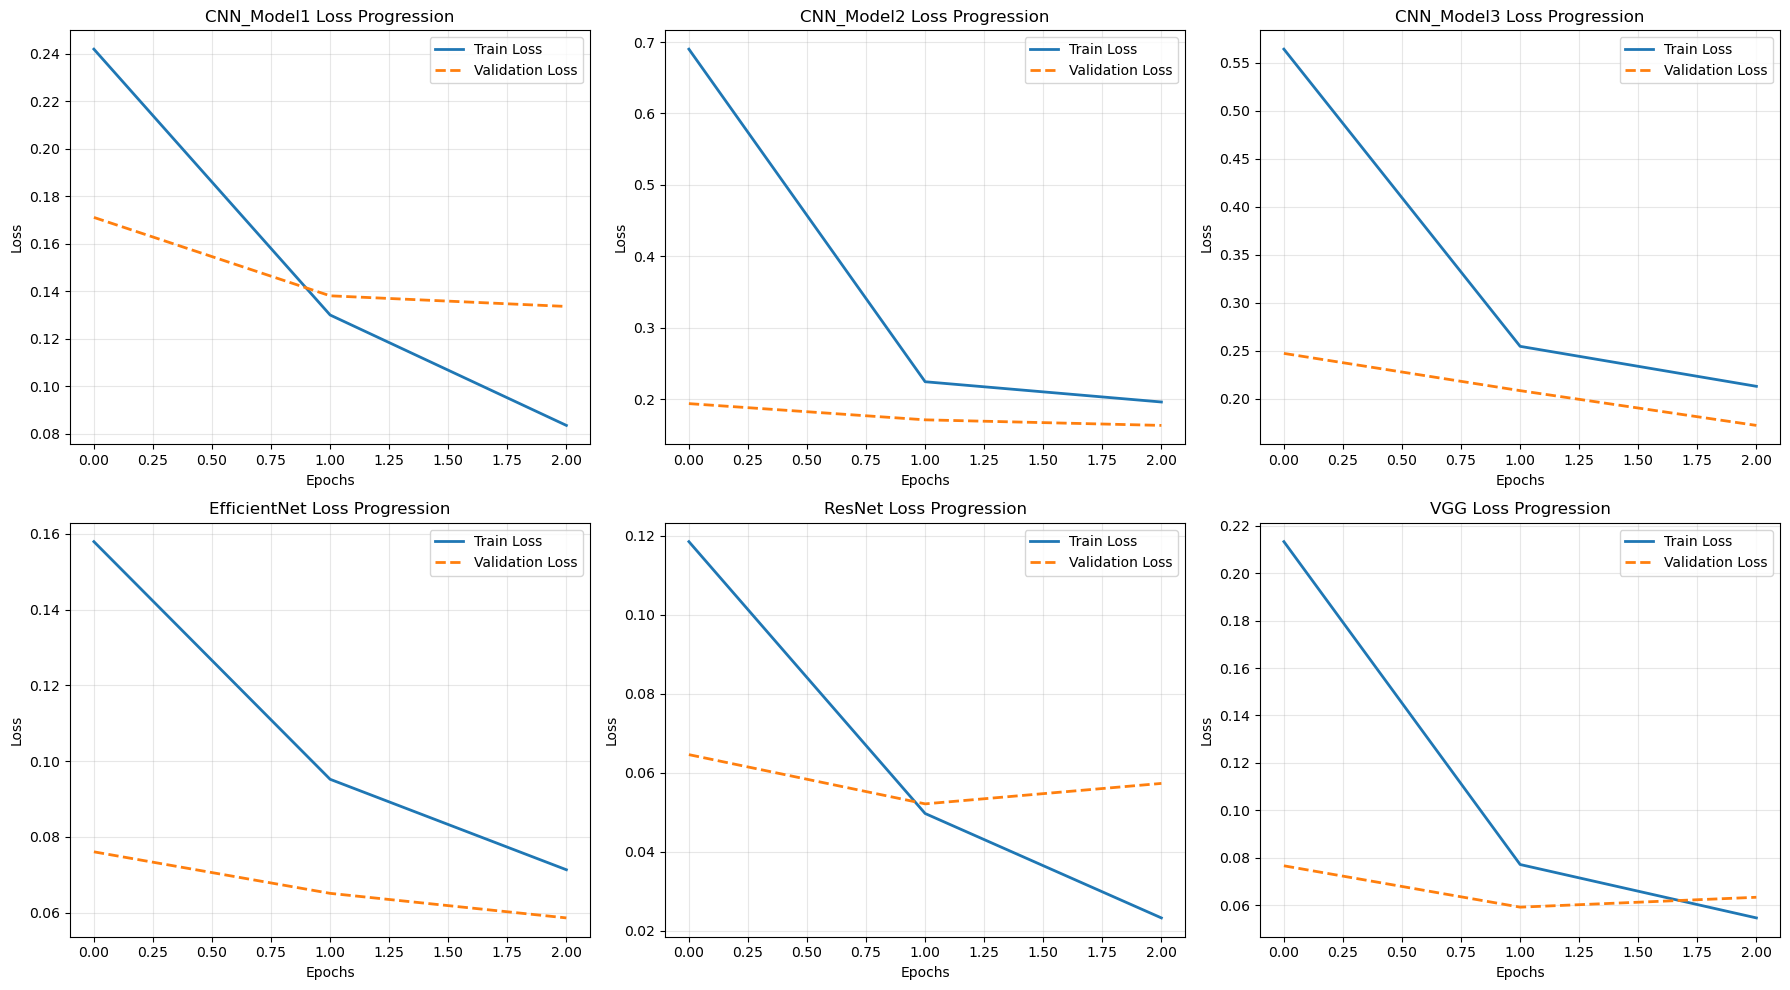

In [228]:
# =============================================
# SECOND PLOT: Loss Comparison
# =============================================
num_models = len(all_histories)
subplot_rows = 2
subplot_cols = 3  # Ajustado para 6 modelos

fig, axs = plt.subplots(subplot_rows, subplot_cols, figsize=(18, 10))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

for idx, (model_name, history) in enumerate(all_histories.items()):
    row = idx // subplot_cols
    col = idx % subplot_cols
    
    ax = axs[row, col]
    ax.plot(history['train']['loss'], label='Train Loss', linewidth=2)
    ax.plot(history['val']['loss'], label='Validation Loss', linewidth=2, linestyle='--')
    
    ax.set_title(f'{model_name} Loss Progression', fontsize=12)
    ax.set_xlabel('Epochs', fontsize=10)
    ax.set_ylabel('Loss', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.legend()

# Remove empty subplot if odd number of models
if num_models % subplot_cols != 0:
    for i in range(num_models, subplot_rows * subplot_cols):
        fig.delaxes(axs.flatten()[i])

plt.tight_layout()
plt.show()

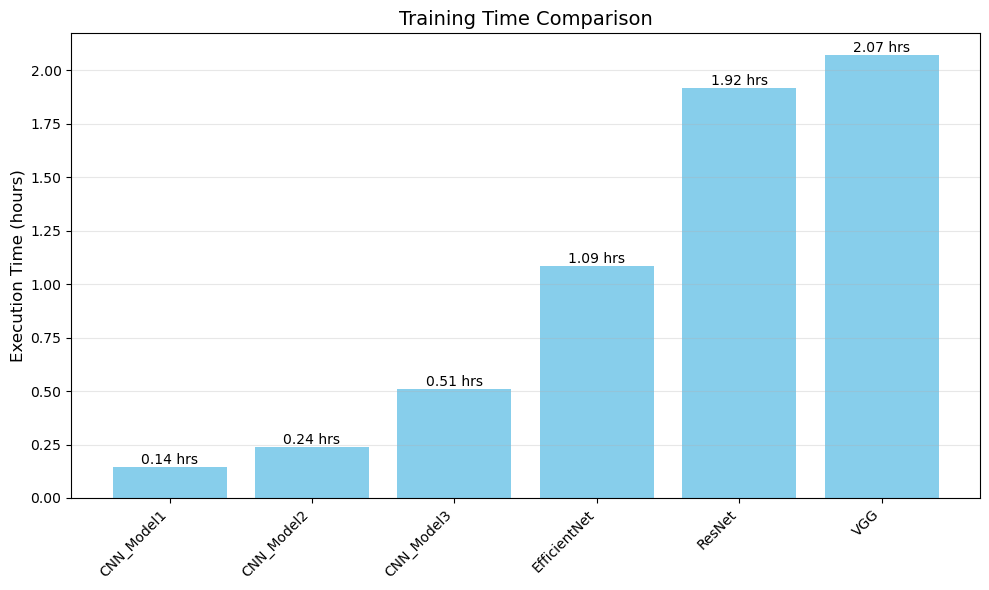

In [230]:
# =============================================
# THIRD PLOT: Execution Time Comparison
# =============================================
plt.figure(figsize=(10, 6))
bars = plt.bar(all_execution_times.keys(), 
               [t / 3600 for t in all_execution_times.values()], 
               color='skyblue')

# Add exact time labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height,
             f'{height:.2f} hrs',
             ha='center', va='bottom')

plt.ylabel('Execution Time (hours)', fontsize=12)
plt.title('Training Time Comparison', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Mejor modelo

In [242]:
#   Find the best model
best_model_name = max(all_results, key=lambda model: test_results[model]['test_accuracy'])
print(f"The best model is: {best_model_name}")


The best model is: ResNet


In [246]:
# Load the best model
best_model_path     = f"{MODELS_SAVED_PATH}best_model_{best_model_name}.pth"
BEST_MODEL_FUNCTION =  MODELS[best_model_name]()
BEST_MODEL_FUNCTION.load_state_dict(torch.load(best_model_path))
BEST_MODEL_FUNCTION.to(DEVICE)
BEST_MODEL_FUNCTION.eval()

/var/folders/fk/v7c5p8wn1knfy26l727g3py40000gn/T/ipykernel_74977/4224797488.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  BEST_MODEL_FUNCTION.load_state_dict(torch.loa

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [271]:
all_predictions = []; all_probabilities = []; all_true_labels = []
misclassified_images = []; misclassified_true_labels = [] ; misclassified_predicted_labels = []

with torch.no_grad():
    for images, labels in tqdm(TEST_LOADER, desc="Evaluating", unit="batch"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs      = BEST_MODEL_FUNCTION(images)
        _, predicted = torch.max(outputs, 1)

        #Metrics calculation 
        all_predictions.extend(predicted.cpu().numpy())
        all_probabilities.extend(probabilities.cpu().numpy())
        all_true_labels.extend(labels.cpu().numpy())
        
        # Find misclassified images
        misclassified_mask = (predicted != labels)
        if misclassified_mask.any():
            misclassified_images.extend(images[misclassified_mask].cpu())
            misclassified_true_labels.extend(labels[misclassified_mask].cpu().numpy())
            misclassified_predicted_labels.extend(predicted[misclassified_mask].cpu().numpy())

# Convert lists to numpy arrays for easier handling
all_predictions   = np.array(all_predictions)
all_probabilities = np.array(all_probabilities)
all_true_labels   = np.array(all_true_labels)

misclassified_images            = torch.stack(misclassified_images).numpy()
misclassified_true_labels       = np.array(misclassified_true_labels)
misclassified_predicted_labels  = np.array(misclassified_predicted_labels)


Evaluating: 100%|█████████████████████████████████| 2763/2763 [02:16<00:00, 20.26batch/s]


In [260]:
# Generate a classification report
print(f"Classification report for {best_model_name}:\n")
print(classification_report(all_true_labels, all_predictions, target_names=CLASS_NAMES))

Classification report for ResNet:

              precision    recall  f1-score   support

       covid       0.98      0.93      0.95       718
      normal       0.98      0.99      0.98      2045

    accuracy                           0.98      2763
   macro avg       0.98      0.96      0.97      2763
weighted avg       0.98      0.98      0.98      2763



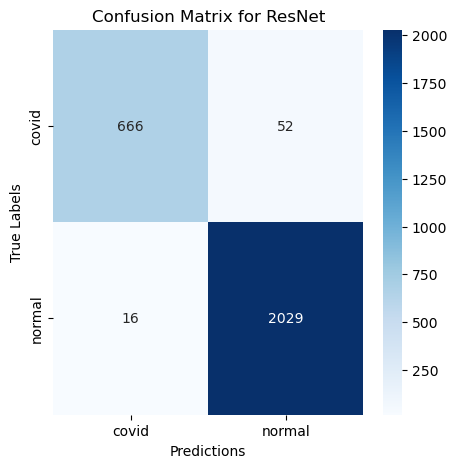

In [266]:
import seaborn as sns  
# Generate the confusion matrix
cm = confusion_matrix(all_true_labels, all_predictions)

# Plot the confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',  # Format as integers
    cmap='Blues',  # Color map
    xticklabels=CLASS_NAMES,  # Class names for x-axis
    yticklabels=CLASS_NAMES   # Class names for y-axis
)
plt.xlabel('Predictions')
plt.ylabel('True Labels')
plt.title(f'Confusion Matrix for {best_model_name}')
plt.show()

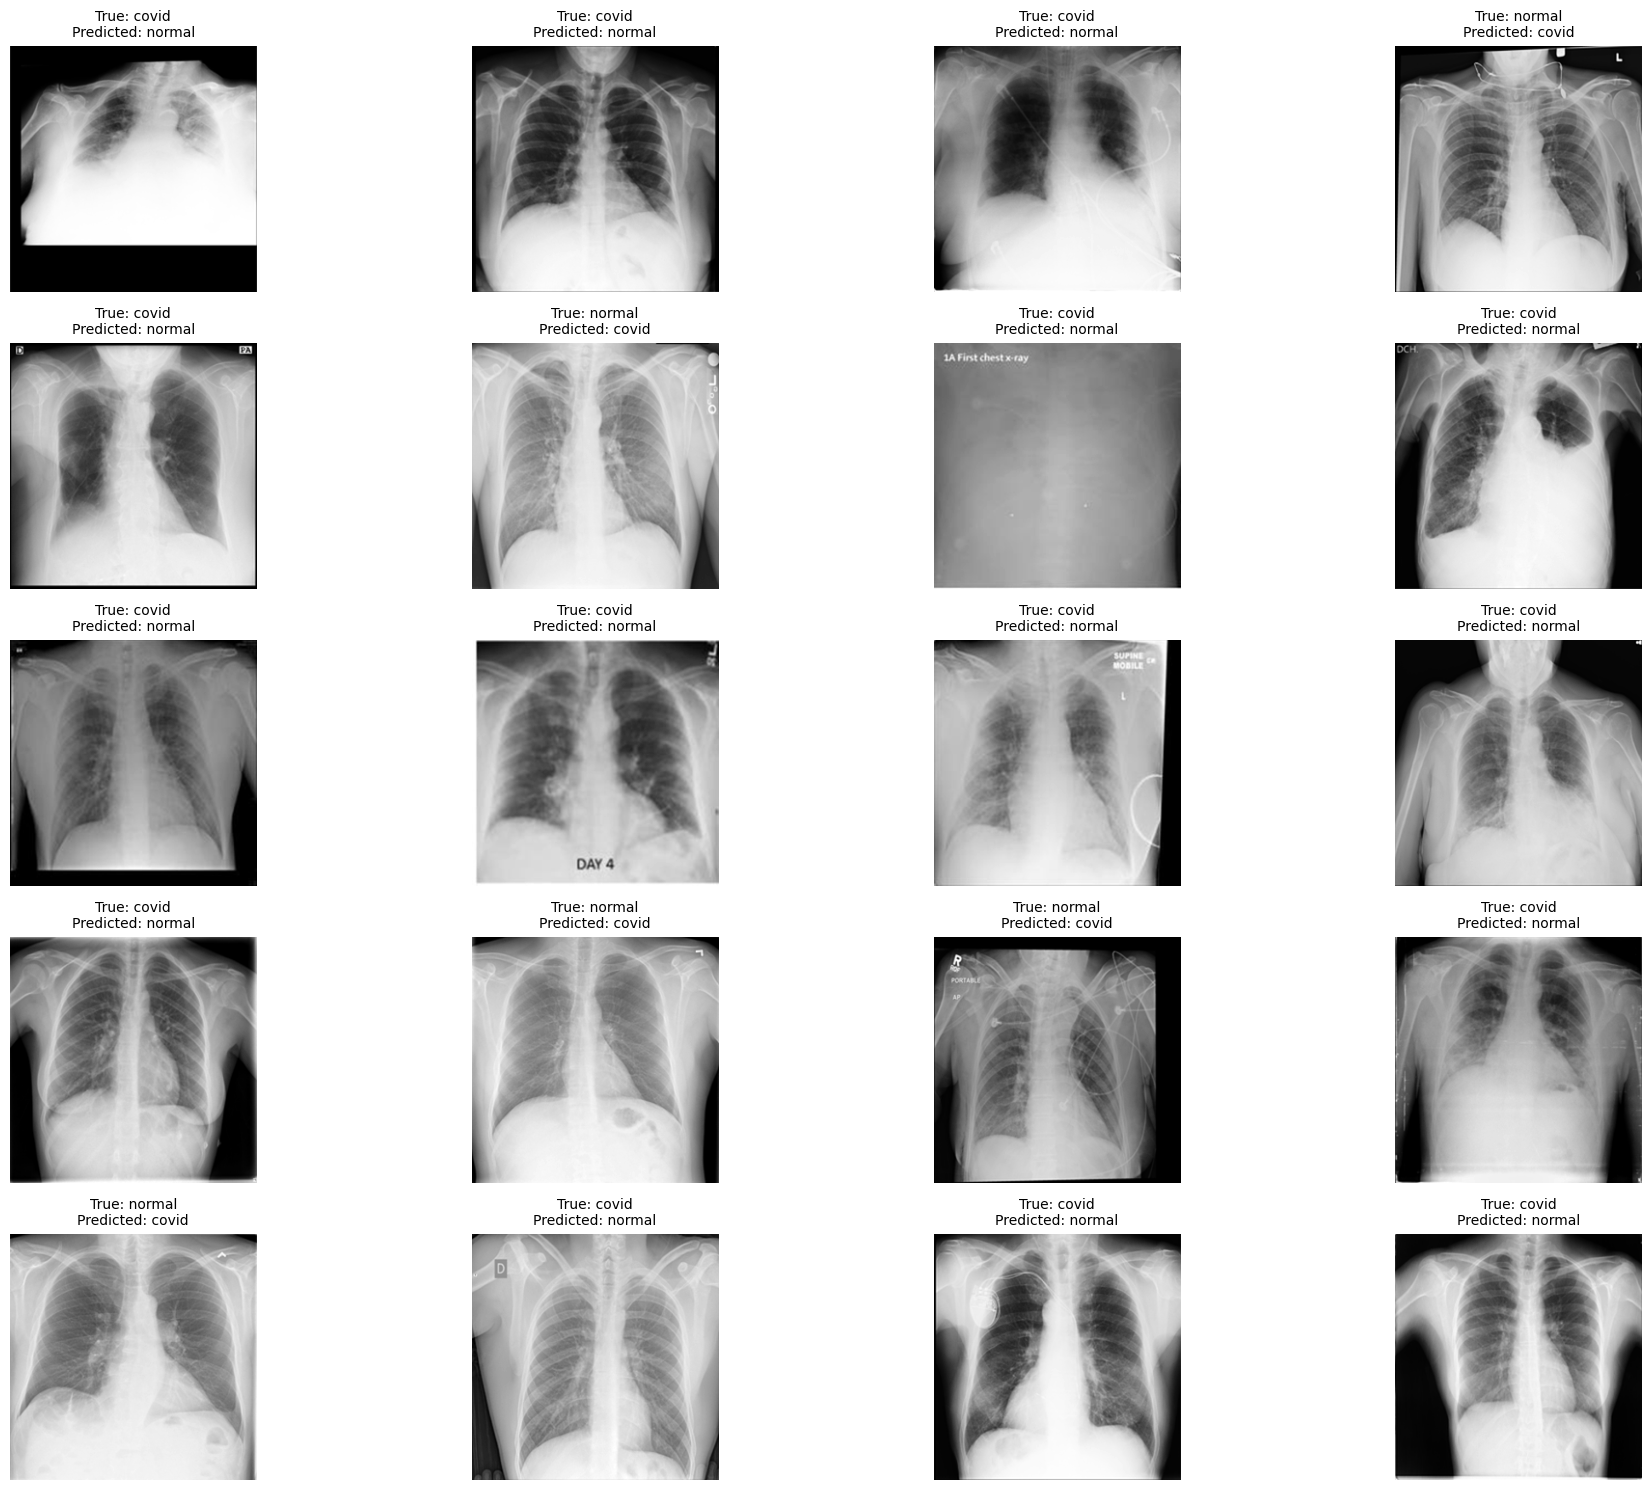

In [319]:
# Visualize misclassified images
def plot_misclassified_images(images, true_labels, predicted_labels, class_names, num_images, fig_size_tup= (15, 10)):
    plt.figure(figsize=fig_size_tup)
    rows = num_images/5 
    cols = int(num_images/5)
    
    for i in range(min(num_images, len(images))):
        
        
        plt.subplot(5, cols, i + 1)
        
        # Convert image tensor to a format suitable for plotting
        img = images[i].transpose(1, 2, 0)  # Change from (C, H, W) to (H, W, C)
        if img.shape[2] == 1:  # Handle grayscale images
            img = img.squeeze()
        
        # Plot the image
        plt.imshow(img, cmap='gray' if img.ndim == 2 else None)
        
        # Add title with true and predicted labels
        true_class = class_names[true_labels[i]]
        predicted_class = class_names[predicted_labels[i]]
        plt.title(f"True: {true_class}\nPredicted: {predicted_class}", fontsize=10)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Step 3: Plot misclassified images
plot_misclassified_images(
    misclassified_images,
    misclassified_true_labels,
    misclassified_predicted_labels,
    class_names,
    num_images=20,  # Number of misclassified images to display
    fig_size_tup = (20, 15)
)